# Quickstart


`AutoEmulate`'s goal is to make it easy to create an emulator for your simulation. Here's the basic workflow:


In [1]:
from autoemulate.experimental.compare import AutoEmulate
from autoemulate.experimental.emulators import *

from autoemulate.experimental.simulations.projectile import Projectile

import warnings
warnings.filterwarnings("ignore")

## Toy simulation

Before we build an emulator with AutoEmulate, we need to get a set of input/output pairs from our simulation to use as training data.

Below is a toy simulation for a projectile's motion with drag (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). The simulation includes:
- Inputs: drag coefficient (log scale), velocity
- Outputs: distance the projectile travelled


In [2]:
projectile = Projectile()

# sample from a simulation
n_samples = 500
x = projectile.sample_inputs(n_samples).float()
y = projectile.forward_batch(x).float()

x.shape, y.shape

Running simulations: 100%|██████████| 500/500 [00:00<00:00, 1.23ksample/s]


(torch.Size([500, 2]), torch.Size([500, 1]))

## Comparing emulators

This is the core of `AutoEmulate`. With a set of inputs / outputs, we can run a full machine learning pipeline, including data processing, model fitting, model selection and hyperparameter optimisation in just a few lines of code. First, let's check the names of the available emulator models.


In [3]:
# Print list of available emulators
AutoEmulate.list_emulators()

,model_name,short_name
0,GaussianProcessExact,GPE
1,GaussianProcessExactCorrelated,GPEC
2,LightGBM,LGBM
3,SupportVectorMachine,SVM
4,RadialBasisFunctions,RBF
5,RandomForest,RF
6,MLP,MLP
7,EnsembleMLP,EMLP
8,EnsembleMLPDropout,EMLPD


Now let's initialise an `AutoEmulate` object.

This provides the simulation inputs and outputs, then fits a range of different models to the data, evaluating on witheld test data.

In [ ]:
ae = AutoEmulate(x, y)

Comparing models:  78%|███████▊  | 7.00/9.00 [01:15<00:28, 14.1s/model]

Look at the summary for a comparison of emulator performace.

In [ ]:
ae.summarise()

,model_name,x_transforms,y_transforms,config,rmse_test,r2_test,r2_test_std,r2_train,r2_train_std
0,GaussianProcessExact,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function linear_mean at 0x...,11.426279,0.999675,0.000221,0.999947,0.000021
6,MLP,[StandardizeTransform()],[StandardizeTransform()],"{'epochs': 200, 'layer_dims': [32, 16], 'lr': ...",19.583685,0.997608,0.000824,0.998844,0.000243
4,RadialBasisFunctions,[StandardizeTransform()],[StandardizeTransform()],"{'kernel': 'thin_plate_spline', 'degree': 2, '...",21.108418,0.996777,0.001492,0.997751,0.000543
3,SupportVectorMachine,[StandardizeTransform()],[StandardizeTransform()],"{'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'...",38.568764,0.967091,0.009685,0.950135,0.006437
1,GaussianProcessExactCorrelated,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function linear_mean at 0x...,40.884655,0.954400,0.012496,0.922193,0.009482
2,LightGBM,[StandardizeTransform()],[StandardizeTransform()],"{'num_leaves': 53, 'max_depth': 9, 'learning_r...",42.747314,0.942399,0.027831,0.995921,0.000928
5,RandomForest,[StandardizeTransform()],[StandardizeTransform()],"{'n_estimators': 117, 'min_samples_split': 18,...",43.862324,0.942085,0.014668,0.947307,0.011386
7,EnsembleMLP,[StandardizeTransform()],[StandardizeTransform()],"{'n_emulators': 6, 'epochs': 50, 'layer_dims':...",44.855186,0.935077,0.008177,0.917923,0.009409
8,EnsembleMLPDropout,[StandardizeTransform()],[StandardizeTransform()],"{'n_emulators': 4, 'epochs': 100, 'layer_dims'...",48.981709,0.908862,0.024332,0.868032,0.015726


Choose an emulator based on the index from the summary dataframe, or quickly get the best result (based on `r2_score`).

In [ ]:
best = ae.best_result()
print("Model ", best.id, " performed best: ", best.model_name)

Model  0  performed best:  GaussianProcessExact


Plot the emulator predictions against the simulator outputs.

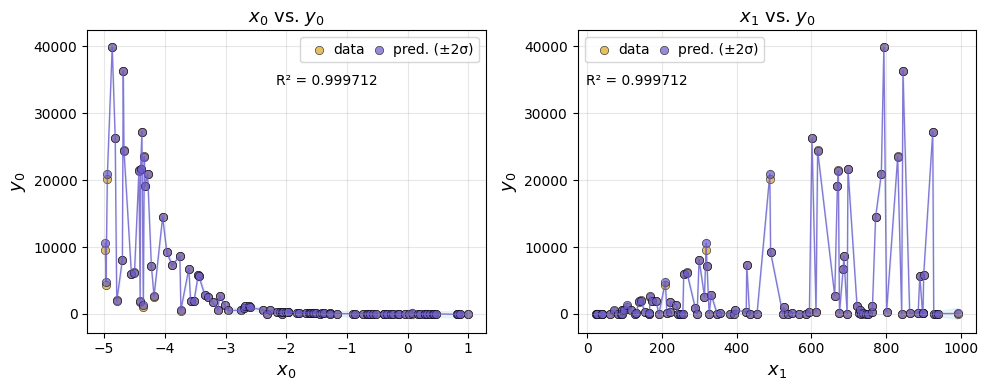

In [ ]:
ae.plot(best)

## Predictions

We can use the model to make predictions for new inputs. Emulators in `AutoEmulate` can use the `predict` method to make predictions.


In [ ]:
best.model.predict(x[:10])

MultitaskMultivariateNormal(mean shape: torch.Size([10, 1]))

# Saving and loading emulators

Emulators can be saved to disk and loaded again later.

In [ ]:
# Make a directory to save Emulator models
import os
path = "my_emulators"
if not os.path.exists(path):
    os.makedirs(path)

Save the best model to disk.

In [ ]:
# The use_timestamp paramater ensures a new model is saved each time the save method is called
best_model_saved = ae.save(best, path, use_timestamp=True)
print("Model saved to: ", best_model_saved)

TypeError: AutoEmulate.save() got an unexpected keyword argument 'use_timestamp'

In [ ]:
loaded_model = ae.load(best_model_saved)

INFO    2025-07-15 15:29:33,239 - autoemulate - Model loaded from my_emulators/GaussianProcessExact_20250715_152905


In [ ]:
loaded_model.predict(x[:10])

MultitaskMultivariateNormal(mean shape: torch.Size([10, 1]))